In [1]:
%matplotlib inline

In [7]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'theano'
import numpy as np
import sklearn as skl
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import backend as K
sns.set_style('darkgrid')

In [8]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [9]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
    return model

earlyStopping = EarlyStopping(monitor='loss', patience=1, mode='auto')

5-fold Cross-validation

In [10]:
from sklearn.model_selection import StratifiedKFold
cvscores = []
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for train, test in kfold.split(x_train, y_train):
    label_train = keras.utils.to_categorical(y_train[train], num_classes)
    label_test = keras.utils.to_categorical(y_train[test], num_classes)
    # Build the model
    model = build_model()
    # Fit the model
    model.fit(x_train[train], label_train, epochs=30, batch_size=64, verbose=1, callbacks=[earlyStopping])
    # evaluate the model
    scores = model.evaluate(x_train[test], label_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1])


Epoch 1/30
47995/47995 [==============================] - 24s 510us/step - loss: 0.2798 - acc: 0.9120
Epoch 2/30
47995/47995 [==============================] - 25s 514us/step - loss: 0.0950 - acc: 0.9720
Epoch 3/30
47995/47995 [==============================] - 25s 516us/step - loss: 0.0706 - acc: 0.9790
Epoch 4/30
47995/47995 [==============================] - 25s 516us/step - loss: 0.0595 - acc: 0.9822
Epoch 5/30
47995/47995 [==============================] - 25s 517us/step - loss: 0.0517 - acc: 0.9843
Epoch 6/30
47995/47995 [==============================] - 25s 518us/step - loss: 0.0479 - acc: 0.9861
Epoch 7/30
47995/47995 [==============================] - 25s 514us/step - loss: 0.0455 - acc: 0.9860
Epoch 8/30
47995/47995 [==============================] - 25s 514us/step - loss: 0.0384 - acc: 0.9881
Epoch 9/30
47995/47995 [==============================] - 25s 514us/step - loss: 0.0377 - acc: 0.9882
Epoch 10/30
47995/47995 [==============================] - 25s 514us/step - loss: 

In [26]:
print("Accuracy: %.4f (+/- %.4f)" % (np.mean(cvscores), np.std(cvscores)))

Accuracy: 0.9921 (+/- 0.0009)


Okay. Now testing on testing set.

In [30]:
%precision 4
predicted = np.argmax(model.predict(x_test), axis=1)
confusion_metrix = skl.metrics.confusion_matrix(y_test, predicted)
print confusion_metrix
inclass_precision = skl.metrics.classification_report(y_test, predicted)
print inclass_precision
loss, acc = model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes), verbose=0)
print 'Accuracy on testing set: %.4f'%acc
print 'Error rate on testing set: %.4f'%(1.-acc)

[[ 978    0    0    0    0    0    1    0    0    1]
 [   0 1130    0    1    0    2    0    2    0    0]
 [   1    0 1021    0    0    0    0   10    0    0]
 [   0    0    0 1009    0    1    0    0    0    0]
 [   0    0    0    0  973    0    2    0    2    5]
 [   0    0    0    9    0  882    1    0    0    0]
 [   1    2    1    0    1    3  949    0    1    0]
 [   0    2    1    0    0    0    0 1024    0    1]
 [   0    0    2    2    0    0    0    0  969    1]
 [   1    0    0    2    3    1    0    1    1 1000]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       980
          1       1.00      1.00      1.00      1135
          2       1.00      0.99      0.99      1032
          3       0.99      1.00      0.99      1010
          4       1.00      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       1.00      0.99      0.99       958
          7       0.99      1.00      0.99  

In [14]:
def plot_embedding(x_emb,y,n,title=''):
    cmap = plt.cm.gist_ncar_r
    ax = plt.subplot()
    for l in xrange(n):
        points = x_emb[y==l,:]
        ax.scatter(points[:,0], points[:,1], label=l, c=cmap(float(l)/float(n)))
    ax.legend(loc='lower right', frameon=True, prop={'size': 10})
    ax.set_title(title)
    plt.show()

In [21]:
from sklearn.manifold import TSNE as tSNE

tsne = tSNE(n_components=2)
emb_testing_img = tsne.fit_transform(np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2])))

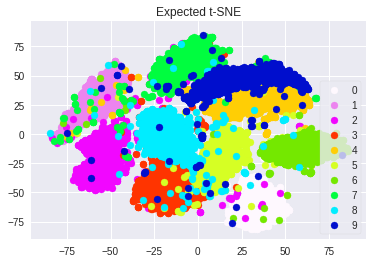

In [32]:
plot_embedding(emb_testing_img, y_test, 10, 'Expected t-SNE')

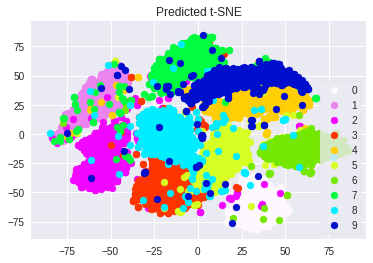

In [33]:
plot_embedding(emb_testing_img, predicted, 10, 'Predicted t-SNE')